<a href="https://colab.research.google.com/github/elsaimo/4106_Final_project/blob/main/SelenaNahraFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading Dataset & Preprocessing**

In [5]:
import torch
import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/content/sample_data/heart_disease_uci.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [6]:
#remove irrelevant columns
df = df.drop(columns=['id','dataset'])

#remove columns with null values
df.isnull().values.any()
df = df.dropna()

df.info()
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 748
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       299 non-null    int64  
 1   sex       299 non-null    object 
 2   cp        299 non-null    object 
 3   trestbps  299 non-null    float64
 4   chol      299 non-null    float64
 5   fbs       299 non-null    object 
 6   restecg   299 non-null    object 
 7   thalch    299 non-null    float64
 8   exang     299 non-null    object 
 9   oldpeak   299 non-null    float64
 10  slope     299 non-null    object 
 11  ca        299 non-null    float64
 12  thal      299 non-null    object 
 13  num       299 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.0+ KB
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')


In [7]:
#encode Male = 0 & Female = 1
df['sex'] = df['sex'].map({'Female': 1, 'Male': 0})

#encode cp, restecg, slope, thal
onehot_encoder = ce.OneHotEncoder(cols=['cp', 'restecg', 'slope', 'thal'])
df = onehot_encoder.fit_transform(df)

#True = 1, False = 0
df[['fbs', 'exang']] = df[['fbs', 'exang']].astype(int)

#scale age, trestbps, chol, thalach, oldpeak, ca
scaler = StandardScaler()
columns_to_scale = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak','ca']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

df.head()

,age,sex,cp_1,cp_2,cp_3,cp_4,trestbps,chol,fbs,restecg_1,...,exang,oldpeak,slope_1,slope_2,slope_3,ca,thal_1,thal_2,thal_3,num
0,0.940446,0,1,0,0,0,0.749760,-0.262867,1,1,...,0,1.069475,1,0,0,-0.718306,1,0,0,0
1,1.384143,0,0,1,0,0,1.596354,0.747722,0,1,...,1,0.380309,0,1,0,2.487269,0,1,0,2
2,1.384143,0,0,1,0,0,-0.661231,-0.339138,0,1,...,1,1.327912,0,1,0,1.418744,0,0,1,1
3,-1.943588,0,0,0,1,0,-0.096835,0.061285,0,0,...,0,2.103224,1,0,0,-0.718306,0,1,0,0
4,-1.499891,1,0,0,0,1,-0.096835,-0.815830,0,1,...,0,0.294163,0,0,1,-0.718306,0,1,0,0


In [8]:
class_distribution = df['num'].value_counts()
sorted_distribution = class_distribution.sort_index()
print(sorted_distribution)

num
0    160
1     56
2     35
3     35
4     13
Name: count, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split
import time
from imblearn.over_sampling import SMOTE
import torch.nn as nn
import torch.optim as optim
import numpy as np

X = df.drop(columns=["num"])
y = df["num"]

print("Shape of X", X.shape)
print("Shape of y", y.shape)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(y_resampled.value_counts())

X = X_resampled.values
y = y_resampled.values.reshape(-1, 1)

print("Shape of X", X.shape)
print("Shape of y", y.shape)


# 80-20 Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_val:', y_val.shape)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long).squeeze()
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long).squeeze()

# Reshape X_val to include a batch dimension
X_val = X_val.unsqueeze(1)
X_train = X_train.unsqueeze(1)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_val:', y_val.shape)

Shape of X (299, 22)
Shape of y (299,)
num
0    160
2    160
1    160
3    160
4    160
Name: count, dtype: int64
Shape of X (800, 22)
Shape of y (800, 1)
Shape of X_train: (640, 22)
Shape of y_train: (640, 1)
Shape of X_val: (160, 22)
Shape of y_val: (160, 1)
Shape of X_train: torch.Size([640, 1, 22])
Shape of y_train: torch.Size([640])
Shape of X_val: torch.Size([160, 1, 22])
Shape of y_val: torch.Size([160])


**Baseline Model**

In [10]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 512
num_layers = 2
num_classes = len(np.unique(y_train))

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 64

start_time = time.time()
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        targets = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)  # Assuming X_val is also properly reshaped
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_val).sum().item() / y_val.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')

Epoch 10, Loss: 0.8833546042442322, Validation Loss: 1.0413864850997925, Validation Accuracy: 0.59375
Epoch 20, Loss: 0.6720016598701477, Validation Loss: 0.8691042065620422, Validation Accuracy: 0.675000011920929
Epoch 30, Loss: 0.4474126994609833, Validation Loss: 0.7613406181335449, Validation Accuracy: 0.762499988079071
Epoch 40, Loss: 0.2691902816295624, Validation Loss: 0.6629627346992493, Validation Accuracy: 0.78125
Epoch 50, Loss: 0.13522937893867493, Validation Loss: 0.6497628092765808, Validation Accuracy: 0.824999988079071
Epoch 60, Loss: 0.05530581995844841, Validation Loss: 0.6957718133926392, Validation Accuracy: 0.8374999761581421
Epoch 70, Loss: 0.025230802595615387, Validation Loss: 0.7532187700271606, Validation Accuracy: 0.84375
Epoch 80, Loss: 0.014302218332886696, Validation Loss: 0.8021672368049622, Validation Accuracy: 0.8374999761581421
Epoch 90, Loss: 0.009241107851266861, Validation Loss: 0.8417107462882996, Validation Accuracy: 0.84375
Epoch 100, Loss: 0.006

**Decreased Batch Size**

In [11]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 512
num_layers = 2
num_classes = len(np.unique(y_train))

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 32

start_time = time.time()
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        targets = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)  # Assuming X_val is also properly reshaped
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_val).sum().item() / y_val.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')

Epoch 10, Loss: 0.6605517864227295, Validation Loss: 0.9497709274291992, Validation Accuracy: 0.625
Epoch 20, Loss: 0.3206775188446045, Validation Loss: 0.7767561674118042, Validation Accuracy: 0.7749999761581421
Epoch 30, Loss: 0.14758531749248505, Validation Loss: 0.6691693067550659, Validation Accuracy: 0.762499988079071
Epoch 40, Loss: 0.05071189999580383, Validation Loss: 0.667228102684021, Validation Accuracy: 0.824999988079071
Epoch 50, Loss: 0.018516723066568375, Validation Loss: 0.741719126701355, Validation Accuracy: 0.824999988079071
Epoch 60, Loss: 0.009601046331226826, Validation Loss: 0.808484673500061, Validation Accuracy: 0.8374999761581421
Epoch 70, Loss: 0.005846016108989716, Validation Loss: 0.8595927357673645, Validation Accuracy: 0.84375
Epoch 80, Loss: 0.0039041824638843536, Validation Loss: 0.9007242918014526, Validation Accuracy: 0.8500000238418579
Epoch 90, Loss: 0.00277151120826602, Validation Loss: 0.9352889060974121, Validation Accuracy: 0.8500000238418579
E

**Increased Batch Size**

In [12]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 512
num_layers = 2
num_classes = len(np.unique(y_train))

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 128

start_time = time.time()
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        targets = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)  # Assuming X_val is also properly reshaped
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_val).sum().item() / y_val.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')

Epoch 10, Loss: 1.0413458347320557, Validation Loss: 1.092245101928711, Validation Accuracy: 0.606249988079071
Epoch 20, Loss: 0.772638738155365, Validation Loss: 1.0165759325027466, Validation Accuracy: 0.5874999761581421
Epoch 30, Loss: 0.6147260069847107, Validation Loss: 0.8910983204841614, Validation Accuracy: 0.675000011920929
Epoch 40, Loss: 0.4609139561653137, Validation Loss: 0.8038209676742554, Validation Accuracy: 0.762499988079071
Epoch 50, Loss: 0.3025098145008087, Validation Loss: 0.694609522819519, Validation Accuracy: 0.78125
Epoch 60, Loss: 0.1798200160264969, Validation Loss: 0.62653648853302, Validation Accuracy: 0.800000011920929
Epoch 70, Loss: 0.0999973714351654, Validation Loss: 0.6138553619384766, Validation Accuracy: 0.831250011920929
Epoch 80, Loss: 0.051952533423900604, Validation Loss: 0.6445295214653015, Validation Accuracy: 0.8500000238418579
Epoch 90, Loss: 0.029413284733891487, Validation Loss: 0.6930103898048401, Validation Accuracy: 0.856249988079071
E

**Decreased Learning Rate**

In [13]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 512
num_layers = 2
num_classes = len(np.unique(y_train))

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
batch_size = 128

start_time = time.time()
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        targets = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)  # Assuming X_val is also properly reshaped
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_val).sum().item() / y_val.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')

Epoch 10, Loss: 0.41908150911331177, Validation Loss: 0.7764045596122742, Validation Accuracy: 0.75
Epoch 20, Loss: 0.1925768256187439, Validation Loss: 0.7866029143333435, Validation Accuracy: 0.8500000238418579
Epoch 30, Loss: 0.0083940913900733, Validation Loss: 0.7350204586982727, Validation Accuracy: 0.824999988079071
Epoch 40, Loss: 0.0007337886490859091, Validation Loss: 0.8101974725723267, Validation Accuracy: 0.8500000238418579
Epoch 50, Loss: 0.0004348775837570429, Validation Loss: 0.8416892290115356, Validation Accuracy: 0.8500000238418579
Epoch 60, Loss: 0.0003210248542018235, Validation Loss: 0.8687556385993958, Validation Accuracy: 0.8500000238418579
Epoch 70, Loss: 0.00025291769998148084, Validation Loss: 0.8900945782661438, Validation Accuracy: 0.8500000238418579
Epoch 80, Loss: 0.00020714689162559807, Validation Loss: 0.9083932638168335, Validation Accuracy: 0.8500000238418579
Epoch 90, Loss: 0.0001740023581078276, Validation Loss: 0.924535870552063, Validation Accurac

**Increased Learning Rate**

In [14]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 512
num_layers = 2
num_classes = len(np.unique(y_train))

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 100
batch_size = 128

start_time = time.time()
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        targets = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)  # Assuming X_val is also properly reshaped
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_val).sum().item() / y_val.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')

Epoch 10, Loss: 1.5754517316818237, Validation Loss: 1.5810415744781494, Validation Accuracy: 0.4625000059604645
Epoch 20, Loss: 1.4430499076843262, Validation Loss: 1.4716531038284302, Validation Accuracy: 0.5249999761581421
Epoch 30, Loss: 1.259675145149231, Validation Loss: 1.3351006507873535, Validation Accuracy: 0.53125
Epoch 40, Loss: 1.178584098815918, Validation Loss: 1.2573845386505127, Validation Accuracy: 0.550000011920929
Epoch 50, Loss: 1.1209704875946045, Validation Loss: 1.1907634735107422, Validation Accuracy: 0.550000011920929
Epoch 60, Loss: 1.0769649744033813, Validation Loss: 1.1421325206756592, Validation Accuracy: 0.5562499761581421
Epoch 70, Loss: 1.0399619340896606, Validation Loss: 1.1143693923950195, Validation Accuracy: 0.5874999761581421
Epoch 80, Loss: 1.0046530961990356, Validation Loss: 1.0974562168121338, Validation Accuracy: 0.606249988079071
Epoch 90, Loss: 0.9701858758926392, Validation Loss: 1.085962176322937, Validation Accuracy: 0.612500011920929
E

**Decreased Hidden Size**

In [15]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(y_train))

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 128

start_time = time.time()
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        targets = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)  # Assuming X_val is also properly reshaped
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_val).sum().item() / y_val.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')

Epoch 10, Loss: 1.236129879951477, Validation Loss: 1.3075587749481201, Validation Accuracy: 0.53125
Epoch 20, Loss: 1.0360203981399536, Validation Loss: 1.1002827882766724, Validation Accuracy: 0.59375
Epoch 30, Loss: 0.8612545132637024, Validation Loss: 1.037637710571289, Validation Accuracy: 0.574999988079071
Epoch 40, Loss: 0.7248517870903015, Validation Loss: 0.95404452085495, Validation Accuracy: 0.612500011920929
Epoch 50, Loss: 0.6158697605133057, Validation Loss: 0.8698398470878601, Validation Accuracy: 0.6875
Epoch 60, Loss: 0.5124571323394775, Validation Loss: 0.8095863461494446, Validation Accuracy: 0.731249988079071
Epoch 70, Loss: 0.4173917770385742, Validation Loss: 0.761499285697937, Validation Accuracy: 0.762499988079071
Epoch 80, Loss: 0.3275279104709625, Validation Loss: 0.717162549495697, Validation Accuracy: 0.78125
Epoch 90, Loss: 0.24872907996177673, Validation Loss: 0.6835249066352844, Validation Accuracy: 0.793749988079071
Epoch 100, Loss: 0.18569450080394745, 

**Increased Hidden Size**

In [16]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 1024
num_layers = 2
num_classes = len(np.unique(y_train))

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 128

start_time = time.time()
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        targets = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)  # Assuming X_val is also properly reshaped
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_val).sum().item() / y_val.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')

Epoch 10, Loss: 0.9237776398658752, Validation Loss: 1.0881974697113037, Validation Accuracy: 0.5687500238418579
Epoch 20, Loss: 0.6875532269477844, Validation Loss: 0.9554742574691772, Validation Accuracy: 0.6625000238418579
Epoch 30, Loss: 0.48805123567581177, Validation Loss: 0.8502192497253418, Validation Accuracy: 0.7437499761581421
Epoch 40, Loss: 0.2908989191055298, Validation Loss: 0.7518893480300903, Validation Accuracy: 0.78125
Epoch 50, Loss: 0.14026883244514465, Validation Loss: 0.7118399143218994, Validation Accuracy: 0.8062499761581421
Epoch 60, Loss: 0.06010519340634346, Validation Loss: 0.7553611993789673, Validation Accuracy: 0.831250011920929
Epoch 70, Loss: 0.025539690628647804, Validation Loss: 0.8338863253593445, Validation Accuracy: 0.84375
Epoch 80, Loss: 0.014166570268571377, Validation Loss: 0.9018069505691528, Validation Accuracy: 0.856249988079071
Epoch 90, Loss: 0.009086927399039268, Validation Loss: 0.9529822468757629, Validation Accuracy: 0.856249988079071

**Decreased Layers**

In [17]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 512
num_layers = 1
num_classes = len(np.unique(y_train))

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 128

start_time = time.time()
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        targets = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)  # Assuming X_val is also properly reshaped
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_val).sum().item() / y_val.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')

Epoch 10, Loss: 1.1453752517700195, Validation Loss: 1.2197041511535645, Validation Accuracy: 0.5249999761581421
Epoch 20, Loss: 0.9493613839149475, Validation Loss: 1.0915298461914062, Validation Accuracy: 0.574999988079071
Epoch 30, Loss: 0.8396369218826294, Validation Loss: 1.0470352172851562, Validation Accuracy: 0.5874999761581421
Epoch 40, Loss: 0.7506884932518005, Validation Loss: 0.9778342247009277, Validation Accuracy: 0.6187499761581421
Epoch 50, Loss: 0.6618204116821289, Validation Loss: 0.9019057154655457, Validation Accuracy: 0.6625000238418579
Epoch 60, Loss: 0.5771304368972778, Validation Loss: 0.8313583135604858, Validation Accuracy: 0.6875
Epoch 70, Loss: 0.5026739239692688, Validation Loss: 0.7740570306777954, Validation Accuracy: 0.6875
Epoch 80, Loss: 0.43849486112594604, Validation Loss: 0.7284032106399536, Validation Accuracy: 0.7124999761581421
Epoch 90, Loss: 0.3822147846221924, Validation Loss: 0.6901136040687561, Validation Accuracy: 0.731249988079071
Epoch 10

**Increased Layers**

In [18]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 1024
num_layers = 3
num_classes = len(np.unique(y_train))

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 128

start_time = time.time()
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        targets = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)  # Assuming X_val is also properly reshaped
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_val).sum().item() / y_val.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')

Epoch 10, Loss: 0.9461323618888855, Validation Loss: 1.1141130924224854, Validation Accuracy: 0.5874999761581421
Epoch 20, Loss: 0.7008374333381653, Validation Loss: 1.020692229270935, Validation Accuracy: 0.6499999761581421
Epoch 30, Loss: 0.4520184397697449, Validation Loss: 1.013663649559021, Validation Accuracy: 0.71875
Epoch 40, Loss: 0.1637815535068512, Validation Loss: 0.9268969297409058, Validation Accuracy: 0.7749999761581421
Epoch 50, Loss: 0.13415315747261047, Validation Loss: 0.9196821451187134, Validation Accuracy: 0.7875000238418579
Epoch 60, Loss: 0.019879527390003204, Validation Loss: 0.8856226801872253, Validation Accuracy: 0.8062499761581421
Epoch 70, Loss: 0.008963358588516712, Validation Loss: 1.0630110502243042, Validation Accuracy: 0.800000011920929
Epoch 80, Loss: 0.005245898850262165, Validation Loss: 1.130030632019043, Validation Accuracy: 0.793749988079071
Epoch 90, Loss: 0.0035409522242844105, Validation Loss: 1.1776807308197021, Validation Accuracy: 0.800000

**Best Parameters Decreased Epochs**

In [19]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 512
num_layers = 2
num_classes = len(np.unique(y_train))

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
batch_size = 128

start_time = time.time()
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        targets = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)  # Assuming X_val is also properly reshaped
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_val).sum().item() / y_val.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')

Epoch 10, Loss: 1.040706992149353, Validation Loss: 1.090061902999878, Validation Accuracy: 0.6000000238418579
Epoch 20, Loss: 0.7803543210029602, Validation Loss: 1.0195931196212769, Validation Accuracy: 0.612500011920929
Epoch 30, Loss: 0.6136579513549805, Validation Loss: 0.8937205076217651, Validation Accuracy: 0.668749988079071
Epoch 40, Loss: 0.44897186756134033, Validation Loss: 0.8051389455795288, Validation Accuracy: 0.7437499761581421
Epoch 50, Loss: 0.2944451868534088, Validation Loss: 0.7136033773422241, Validation Accuracy: 0.75
Total training time: 25.00 seconds
Accuracy on test set: 0.75


**Best Parameters 150 Epochs**



In [20]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 512
num_layers = 2
num_classes = len(np.unique(y_train))

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 150
batch_size = 128

start_time = time.time()
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        targets = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)  # Assuming X_val is also properly reshaped
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_val).sum().item() / y_val.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')

Epoch 10, Loss: 1.0357604026794434, Validation Loss: 1.0915412902832031, Validation Accuracy: 0.6000000238418579
Epoch 20, Loss: 0.7661163806915283, Validation Loss: 1.0200120210647583, Validation Accuracy: 0.6000000238418579
Epoch 30, Loss: 0.6007979512214661, Validation Loss: 0.8815070986747742, Validation Accuracy: 0.668749988079071
Epoch 40, Loss: 0.43473079800605774, Validation Loss: 0.7865378260612488, Validation Accuracy: 0.7562500238418579
Epoch 50, Loss: 0.28421440720558167, Validation Loss: 0.6907137632369995, Validation Accuracy: 0.7875000238418579
Epoch 60, Loss: 0.1757783591747284, Validation Loss: 0.647283673286438, Validation Accuracy: 0.800000011920929
Epoch 70, Loss: 0.1053006574511528, Validation Loss: 0.6567003726959229, Validation Accuracy: 0.824999988079071
Epoch 80, Loss: 0.058866746723651886, Validation Loss: 0.6940807104110718, Validation Accuracy: 0.84375
Epoch 90, Loss: 0.032542865723371506, Validation Loss: 0.7390006184577942, Validation Accuracy: 0.84375
Epo

**Best Model**

In [24]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 512
num_layers = 2
num_classes = len(np.unique(y_train))

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 128

start_time = time.time()

all_predicted = []
all_labels = []


for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        targets = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)  # Assuming X_val is also properly reshaped
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_val).sum().item() / y_val.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')

Epoch 10, Loss: 1.036211371421814, Validation Loss: 1.083229422569275, Validation Accuracy: 0.6000000238418579
Epoch 20, Loss: 0.7672359347343445, Validation Loss: 1.0135867595672607, Validation Accuracy: 0.612500011920929
Epoch 30, Loss: 0.6037605404853821, Validation Loss: 0.8933809399604797, Validation Accuracy: 0.675000011920929
Epoch 40, Loss: 0.44252699613571167, Validation Loss: 0.8063153028488159, Validation Accuracy: 0.75
Epoch 50, Loss: 0.29102885723114014, Validation Loss: 0.7067192792892456, Validation Accuracy: 0.7875000238418579
Epoch 60, Loss: 0.17295947670936584, Validation Loss: 0.6449040174484253, Validation Accuracy: 0.793749988079071
Epoch 70, Loss: 0.09708128124475479, Validation Loss: 0.6368268132209778, Validation Accuracy: 0.8187500238418579
Epoch 80, Loss: 0.051348838955163956, Validation Loss: 0.6631821990013123, Validation Accuracy: 0.824999988079071
Epoch 90, Loss: 0.02958589792251587, Validation Loss: 0.704748272895813, Validation Accuracy: 0.83125001192092

calculate TP,TN,FP and FN

In [25]:
# Calculating TP, TN, FP, FN
TP = torch.sum((predicted == 1) & (y_val == 1)).item()
TN = torch.sum((predicted == 0) & (y_val == 0)).item()
FP = torch.sum((predicted == 1) & (y_val == 0)).item()
FN = torch.sum((predicted == 0) & (y_val == 1)).item()
total = TP + TN + FP + FN

TP_rate = TP / total
TN_rate = TN / total
FP_rate = FP / total
FN_rate = FN / total

print(f'Epoch {epoch+1}: Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')
print(f' TP: {TP}\n TN: {TN}\n FP: {FP}\n FN: {FN}')
print(f'TP Rate: {TP_rate}, TN Rate: {TN_rate}, FP Rate: {FP_rate}, FN Rate: {FN_rate}')

Epoch 100: Loss: 0.019015774130821228, Validation Loss: 0.7445149421691895, Validation Accuracy: 0.84375
 TP: 29
 TN: 22
 FP: 6
 FN: 0
TP Rate: 0.5087719298245614, TN Rate: 0.38596491228070173, FP Rate: 0.10526315789473684, FN Rate: 0.0


Accuracy: 0.75375
Precision: 0.7602841530972004
Recall: 0.75375
F1 Score: 0.7540988174174882


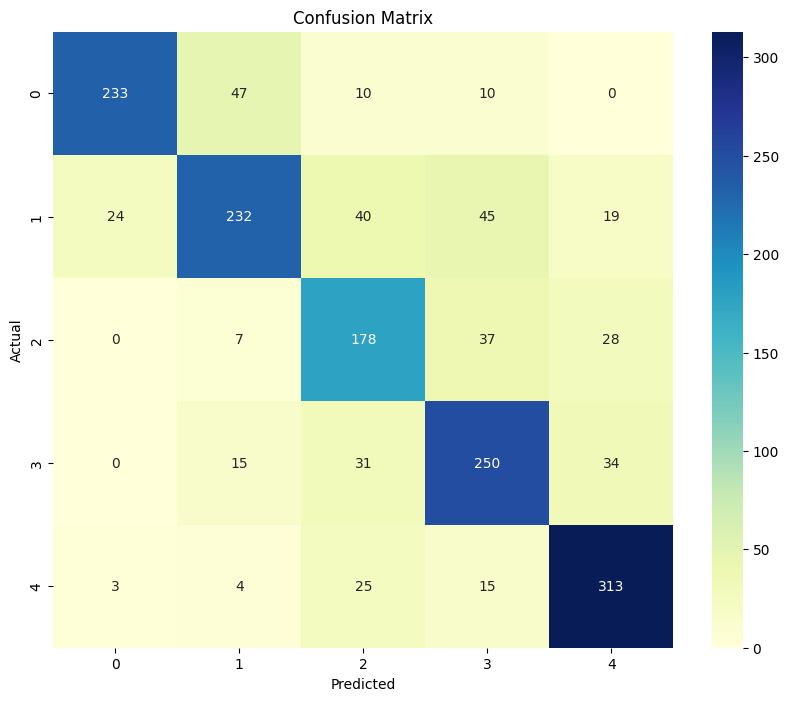

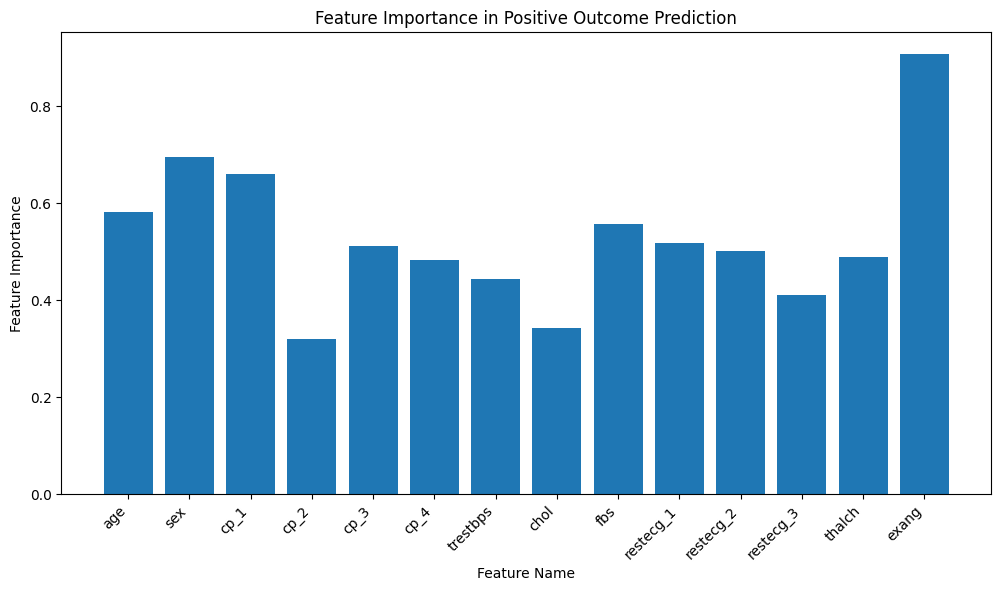

In [27]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Create the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
f1 = f1_score(all_labels, all_predicted, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

learned_weights = model.fc.weight.detach().cpu().numpy()

feature_names = df.columns[:14]

feature_importance = np.abs(learned_weights).sum(axis=0)

plt.figure(figsize=(12, 6))
feature_importance = feature_importance[:14]
plt.bar(feature_names, feature_importance)
plt.xticks(rotation=45, ha="right")
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Positive Outcome Prediction')
plt.show()